# Imports

In [63]:
import pandas as pd
from os import walk
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from PIL import Image
from wordcloud import WordCloud

import nltk
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Constants

In [86]:
EXAMPLE_FILE = '01_Processing/practice_email.txt'
SPAM_1_PATH = '01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = '01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = '01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = '01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

TRAINING_DATA_FILE = '02_Training/train-data.txt'
TEST_DATA_FILE = '02_Training/test-data.txt'

VOCAB_SIZE = 2500
VOCAB_WORD_FILE = '01_Processing/word-by-ids.csv'
THUMBS_UP_ICON = '01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_ICON = '01_Processing/wordcloud_resources/thumbs-down.png'
DATA_JSON_FILE = '01_Processing/email-text-data.json'

# Reading Files

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body=True
        
stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Email body generator

In [6]:
def email_body_generator(path):
    for root, dirname, filename in walk(path):
        for file_name in filename:
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line=='\n':
                    is_body=True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [7]:
def df_from_directory(path, classification):
    rows=[]
    row_names=[]
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [8]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [9]:
spam_emails.shape

(1898, 2)

In [10]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [11]:
data = pd.concat([spam_emails, ham_emails])
data.shape

(5799, 2)

In [12]:
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [13]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data cleaning: null values

In [14]:
data['MESSAGE'].isnull().values.any()

False

In [15]:
(data['MESSAGE'].str.len() == 0).any()

True

In [16]:
(data['MESSAGE'].str.len() == 0).sum()

3

In [17]:
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [18]:
type(data['MESSAGE'].str.len() == 0)

pandas.core.series.Series

In [19]:
data[data['MESSAGE'].str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
data.index.get_loc('cmds').sum()

3

### remove empty file entries

In [21]:
data = data.drop('cmds')

In [22]:
data[data['MESSAGE'].str.len() == 0].index

Index([], dtype='object')

### add document IDs to track emails in dataset

In [23]:
doc_id = range(0, len(data.index))
data['DOC_ID'] = doc_id
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int32

In [24]:
data['FILENAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data

,MESSAGE,CATEGORY,FILENAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


# Saving data in json

In [25]:
data.to_json(DATA_JSON_FILE)

# data visualization

In [26]:
amount_spam = data.CATEGORY.value_counts()[1]
amount_ham = data.CATEGORY.value_counts()[0]

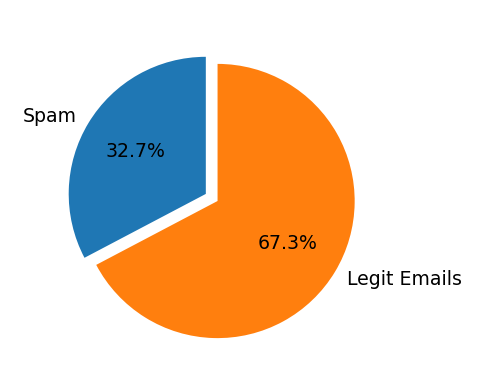

In [27]:
category_names=['Spam', 'Legit Emails']
sizes = [amount_spam, amount_ham]
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, explode={0, 0.1}, startangle=90, autopct='%1.1f%%')
plt.show()

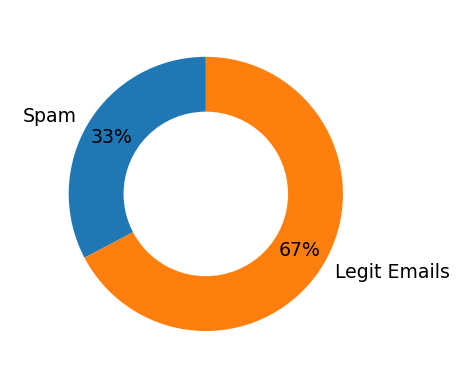

In [28]:
category_names=['Spam', 'Legit Emails']
sizes = [amount_spam, amount_ham]

plt.figure(figsize=(2, 2), dpi=227)


plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90, autopct='%1.0f%%', pctdistance=0.8)
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()


# Natural Language Processing

## Text Preprocessing

### Downloading nltk resoures

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenising

In [31]:
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())


['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

### Removing stopwords

In [32]:
stop_words = set(stopwords.words('english'))
type(stop_words)

set

In [33]:
# lower case, tokenise and remove stop words
msg = 'All work and no play makes Jack a dull boy. '
words = word_tokenize(msg.lower())
filtered_list=[]

stemmer = PorterStemmer()

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_list.append(stemmed_word)
        
filtered_list

['work', 'play', 'make', 'jack', 'dull', 'boy', '.']

## Removing punctuation

In [34]:
msg = 'All work and no play makes Jack a dull boy. '
words = word_tokenize(msg.lower())
filtered_list=[]

stemmer = PorterStemmer()

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_list.append(stemmed_word)
        
filtered_list

['work', 'play', 'make', 'jack', 'dull', 'boy']

## Removing html tags

In [35]:
data.at[28, 'MESSAGE']

'<html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<center>\n\n<font face=3D"times" size=3D"6" color=3D"#000000">Save up to\n\n\n\n<font color=3D"#ff0000">75%</font> on your Term Life\n\nInsurance!</font>\n\n<br>  \n\n<font face=3D"times" size=3D"4" color=3D"#000000">\n\n<i>Compare rates from top insurance companies around\n\nthe country</i></font>\n\n<br><br>\n\n<font face=3D"arial" size=3D"4" color=3D"#7084D6">\n\n<b>In our life and times, it\'s important to plan for\n\nyour family\'s future, while \n\n<br>being comfortable financially.  Choose the right\n\nLife Insurance policy today.</font>\n\n<p>\n\n<font face=3D"arial" size=3D"3" color=3D"#000000">\n\n<i>Click the link below to compare the lowest rates\n\nand save up to <font\n\ncolor=3D"#ff0000">75%</font></i></b></font>  \n\n<p>\n\n<a\n\nhref=3D"http://insurancequotesource.com/user0202/termquotes/473400/"><font\n\nface=3D"arial"\n\nsize=3D"4">\n\n<b>COMPARE YOUR COVERAGE</b></font></a>\n\n<p>\n\n<font face=3D"times" size=3D"5" color

In [36]:
soup = BeautifulSoup(data.at[28, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<html>
 <head>
 </head>
 <body>
  <center>
   <font color='3D"#000000"' face='3D"times"' size='3D"6"'>
    Save up to
    <font color='3D"#ff0000"'>
     75%
    </font>
    on your Term Life

Insurance!
   </font>
   <br/>
   <font color='3D"#000000"' face='3D"times"' size='3D"4"'>
    <i>
     Compare rates from top insurance companies around

the country
    </i>
   </font>
   <br/>
   <br/>
   <font color='3D"#7084D6"' face='3D"arial"' size='3D"4"'>
    <b>
     In our life and times, it's important to plan for

your family's future, while
     <br/>
     being comfortable financially.  Choose the right

Life Insurance policy today.
    </b>
   </font>
   <p>
    <font color='3D"#000000"' face='3D"arial"' size='3D"3"'>
     <i>
      Click the link below to compare the lowest rates

and save up to
      <font color='3D"#ff0000"'>
       75%
      </font>
     </i>
    </font>
    <p>
     <a href='3D"http://insurancequotesource.com/user0202/termquotes/473400/"'>
      <font face='3

## function for email processing

In [37]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_words = soup.get_text()
    words = word_tokenize(cleaned_words.lower())
    
    filtered_words=[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [38]:
clean_msg_no_html(data.at[28, 'MESSAGE'])

['save',
 'term',
 'life',
 'insur',
 'compar',
 'rate',
 'top',
 'insur',
 'compani',
 'around',
 'countri',
 'life',
 'time',
 'import',
 'plan',
 'famili',
 'futur',
 'comfort',
 'financi',
 'choos',
 'right',
 'life',
 'insur',
 'polici',
 'today',
 'click',
 'link',
 'compar',
 'lowest',
 'rate',
 'save',
 'compar',
 'coverag',
 'abl',
 'compar',
 'rate',
 'get',
 'free',
 'applic',
 'less',
 'minut',
 'get',
 'free',
 'instant',
 'quot',
 'compar',
 'lowest',
 'price',
 'select',
 'compani',
 'appli',
 'onlin',
 'get',
 'free',
 'quot',
 'ca',
 'predict',
 'futur',
 'alway',
 'prepar',
 'exclud',
 'futur',
 'contact',
 'tucker']

# Applying cleaning and tokenisation to all messages

In [39]:
data.MESSAGE.iloc[0:3]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

In [40]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_msg_no_html)

In [41]:
flat_list=[]
for sublist in nested_list:
    for item in sublist:
        flat_list.append(item)
len(flat_list)

192

In [42]:
%%time

nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\Lenovo\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 2min


In [43]:
nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

### Slicing data using logic

In [44]:
data[data.CATEGORY ==1].tail()

,MESSAGE,CATEGORY,FILENAME
DOC_ID,,,
1891,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979
1894,****Mid-Summer Customer Appreciation SALE!****...,1,01399.2319643317e2c5193d574e40a71809c2
1895,ATTN:SIR/MADAN \n\n\n\n ...,1,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [45]:
doc_ids_spam = data[data.CATEGORY ==1].index
doc_ids_ham = data[data.CATEGORY ==0].index

In [46]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [47]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

In [48]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] #total number of unique words in non spam emails

20815

In [49]:
#top 10 most used words
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [50]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()

spam_words.shape[0]#total number of unique words in spam emails

13242

In [51]:
#top 10 most used words
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

## Word cloud 

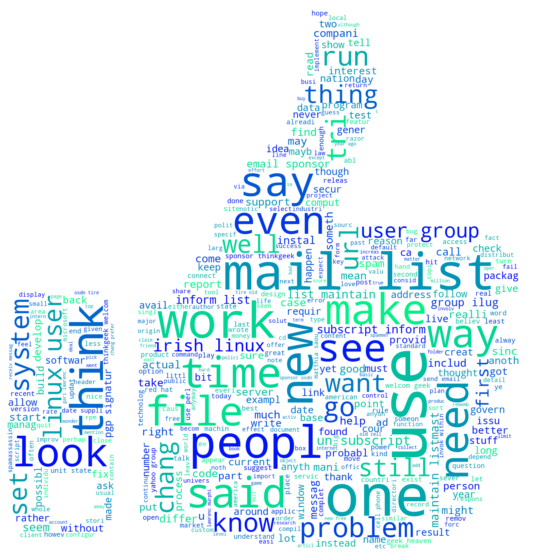

In [52]:
icon = Image.open(THUMBS_UP_ICON)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words=400, colormap='winter')
                       
word_cloud.generate(ham_str)
                       
plt.figure(figsize=[12,10])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

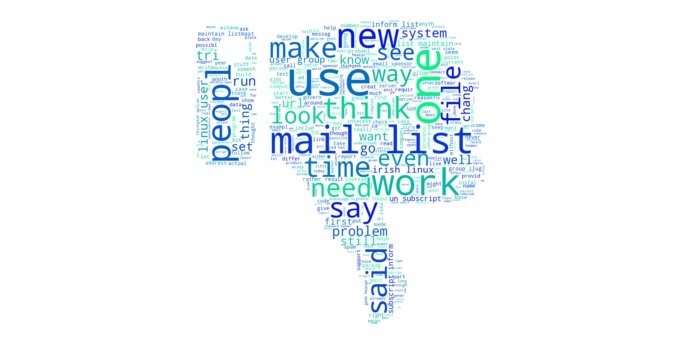

In [53]:
icon = Image.open(THUMBS_DOWN_ICON)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words=400, colormap='winter')
                       
word_cloud.generate(spam_str)
                       
plt.figure(figsize=[12, 10])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Volabulary

In [54]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\Lenovo\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [55]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
unique_words.head()


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [56]:
frequent_words = unique_words[0:VOCAB_SIZE]

In [57]:
#create vocabulary dataframe with word_id
word_ids=list(range(0, VOCAB_SIZE))
vocab=pd.DataFrame({'vocab_words':frequent_words.index.values}, index=word_ids)
vocab.index.name='WORD_IDS'
vocab.head()

,vocab_words
WORD_IDS,
0,http
1,use
2,list
3,email
4,get


In [58]:
vocab.to_csv(VOCAB_WORD_FILE, index_label = vocab.index.name, header=vocab.vocab_words.name)

## Generating sparse matrix

In [60]:
stemmed_nested_list.tolist()

[['save',
  'life',
  'insur',
  'spend',
  'life',
  'quot',
  'save',
  'g',
  'famili',
  'financi',
  'secur',
  'import',
  'life',
  'quot',
  'save',
  'ke',
  'buy',
  'life',
  'insur',
  'simpl',
  'afford',
  'provid',
  'free',
  'access',
  'best',
  'compani',
  'lowest',
  'rate',
  'life',
  'quot',
  'save',
  'fast',
  'save',
  'money',
  'let',
  'us',
  'help',
  'get',
  'start',
  'best',
  'ue',
  'countri',
  'new',
  'coverag',
  'save',
  'hundr',
  'even',
  'usand',
  'dollar',
  'request',
  'free',
  'quot',
  'lifequot',
  'save',
  'servic',
  'take',
  'less',
  'minut',
  'complet',
  'shop',
  'compar',
  'save',
  'type',
  'life',
  'insur',
  'click',
  'free',
  'quot',
  'protect',
  'famili',
  'best',
  'invest',
  'r',
  'make',
  'receipt',
  'email',
  'error',
  'wish',
  'remov',
  'list',
  'pleas',
  'click',
  'type',
  'remov',
  'resid',
  'state',
  'prohibit',
  'solicit',
  'ce',
  'pleas',
  'disregard',
  'email'],
 ['fight',
  

In [61]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,http,bizarr,collect,stuf,anim,could,fetch,sold,cornwal,museum,...,None,None,None,None,None,None,None,None,None,None
5792,care,use,one,also,realli,cute,thing,japanes,av,girl,...,None,None,None,None,None,None,None,None,None,None
5793,sm,skip,montanaro,write,jeremi,put,anoth,way,interest,hear,...,None,None,None,None,None,None,None,None,None,None
5794,mark,hammond,like,given,zodb,sound,attract,would,packag,hundr,...,None,None,None,None,None,None,None,None,None,None


In [62]:
word_columns_df.shape #7671 is the number of words in the longest email

(5796, 7671)

### Splitting into training and test data

In [68]:
word_index = pd.Index(vocab.vocab_words)
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'advisor', 'boom', 'raid', 'distributor', 'contest', 'anthoni', 'steal',
       'cloth', 'su', 'manner'],
      dtype='object', name='vocab_words', length=2500)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [97]:
X_test.shape

(1739, 7671)

In [99]:
X_train.shape

(4057, 7671)

In [67]:
X_train.index.name = X_test.index.name = 'DOC_ID'

### Sparse matrix from X_train

In [73]:
def make_sparse_matrix(df, indexed_words, labels):
    '''
    df: X_train or X_test/ Dataframe with words in columns and doc_id as index
    indexed_words: index of words ordered by word_id
    labels: category/y_train or y_test
    '''
    rows=df.shape[0]
    columns=df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(rows):
        for j in range(columns):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)
    

In [74]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 58min 23s


In [100]:
sparse_train_df.shape 

(429231, 4)

In [101]:
train_grouped=sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [77]:
train_grouped = train_grouped.reset_index()
train_grouped

,index,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,2,1,1
1,1,0,3,1,2
2,2,0,4,1,1
3,3,0,7,1,3
4,4,0,11,1,1
...,...,...,...,...,...
258360,258360,5795,2039,0,1
258361,258361,5795,2041,0,1
258362,258362,5795,2257,0,1
258363,258363,5795,2329,0,1


In [87]:
#Save in txt file
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

## Making test data sparse  matrix and saving it

In [89]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [102]:
sparse_test_df.shape

(203378, 4)

In [103]:
test_grouped=sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped = test_grouped.reset_index()
test_grouped.shape

(117791, 4)

In [91]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

## Pre processing data subtleties 

In [92]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [93]:
len(test_doc_ids)

1724

In [94]:
len(X_test)

1739

In [95]:
set(X_test.index.values) - test_doc_ids # some emails are missing in the test_grouped because none of the words in those 
                                        #emails are present in the 2500 vocab words(mostly gibberish words)

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}